In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import os
import psutil

# import lightgbm as lgb
# from sklearn.model_selection import train_test_split
import random
import sklearn
from itertools import cycle, islice

import warnings
warnings.filterwarnings("ignore")

# from tqdm.notebook import tqdm
# pd.set_option('max_columns', 500)
# plt.style.use('fivethirtyeight')

In [2]:
# Read in data
tracks = pd.read_csv('../in/PlayerTrackData.csv',
                        dtype={'time':'float64',
                                'x':'float16',
                                'y':'float16',
                                'dir': 'float16',
                                'dis': 'float16',
                                'o':'float16',
                                's':'float16'})

# plays = pd.read_csv('../in/PlayList.csv')
# injury = pd.read_csv('../in/InjuryRecord.csv')

# # Create injury detailed by merging on play information
# injury_detailed = injury.merge(plays, how='left')
# injury_detailed = injury_detailed.merge(plays[['PlayerKey','RosterPosition']].drop_duplicates() \
#                                             .rename(columns={'RosterPosition':'RosterPosition_notplay'}))
# injury_detailed['RosterPosition_notplay'] = injury_detailed['RosterPosition_notplay'] \
#     .replace({'Safety':'Defensive Back',
#               'Cornerback' : 'Defensive Back'})

In [3]:
# plt.style.use('fivethirtyeight')
# # Find Injury Rate by Surface
# injury_playkeys = injury['PlayKey'].unique()
# plays['counter'] = 1 # Column used when grouping to count
# plays['isInjuryPlay'] = False
# plays.loc[plays['PlayKey'].isin(injury_playkeys), 'isInjuryPlay'] = True

# # Plot Results
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# (plays.groupby('FieldType')[['isInjuryPlay']].mean() * 100000).plot(kind='bar', ax=ax)
# ax.get_legend().remove()
# ax.set_xlabel('')
# ax.set_title('Lower Body Injury Rate by Surface')
# ax.set_ylabel('Injury per \n 100,000 plays', rotation=0, fontsize=13, color='darkgrey')
# ax.yaxis.set_label_coords(-0.12,0.85)
# for p in ax.patches:
#     ax.annotate(f'{int(p.get_height())}',
#                 (p.get_x() + 0.20,
#                  p.get_height() - 3),
#                  fontsize=20,
#                 color='white')
# ax.axhline(0, color='k')
# plt.xticks(rotation=0)
# plt.show()

In [4]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# ax = axes[0]
# injury_detailed.groupby('RosterPosition_notplay')['PlayerKey'].count().sort_values() \
#     .plot(kind='barh', title='Non-Contact Injuries', figsize=(10, 5), ax=ax)
# count = 0
# for x in ax.patches:
#     if count > 3:
#         x.set_color('orange')
#     count += 1
# # plt.annotate('Three positions account for 2/3 of injuries', xy=(15, 1.5), fontsize=15, color='brown')
# # plt.arrow(15, 2, -0.3, 1, color='brown', head_width=0.2, head_length=0.2, lw=3)
# ax.set_title('All Non-Contact Injuries', fontsize=15)
# ax.grid(b=None, axis='y')
# ax.set_ylabel('')
# ax.set_xlabel('Injury Count', fontsize=15)
# ax.axvline(0.1, color='black')
# ax2 = axes[1]
# injury_detailed.query('DM_M7 == 1').groupby('RosterPosition_notplay')['PlayerKey'] \
#     .count() \
#     .sort_values() \
#     .plot(kind='barh', figsize=(15, 5), ax=ax2)
# count = 0
# for x in ax2.patches:
#     if count > 3:
#         x.set_color('orange')
#     count += 1
# ax2.set_title('Non-Contact Injury > 1 week missed', fontsize=15)
# ax2.grid(b=None, axis='y')
# ax2.set_xlabel('Injury Count', fontsize=15)
# ax2.set_ylabel('')
# plt.subplots_adjust(wspace = 0.4)
# fig.suptitle('3 Positions account for 70% of all injuries', fontsize=20)
# plt.subplots_adjust(top=0.83)

# rects = ax.patches
# # For each bar: Place a label
# for rect in rects:
#     # Get X and Y placement of label from rect.
#     x_value = rect.get_width()
#     y_value = rect.get_y() + rect.get_height() / 2

#     # Number of points between bar and label. Change to your liking.
#     space = -20
#     # Vertical alignment for positive values
#     ha = 'left'

#     # If value of bar is negative: Place label left of bar
#     if x_value < 0:
#         # Invert space to place label to the left
#         space *= -1
#         # Horizontally align label at right
#         ha = 'right'

#     # Use X value as label and format number with one decimal place
#     label = "{:.0f}".format(x_value)

#     # Create annotation
#     ax.annotate(
#         label,                      # Use `label` as label
#         (x_value, y_value),         # Place label at end of the bar
#         xytext=(space, 0),          # Horizontally shift label by `space`
#         textcoords="offset points", # Interpret `xytext` as offset in points
#         va='center',                # Vertically center label
#         ha=ha,
#         fontsize=14,
#         color='white')                      # Horizontally align label differently for
#                                     # positive and negative values.
        
        
# rects = ax2.patches
# # For each bar: Place a label
# for rect in rects:
#     # Get X and Y placement of label from rect.
#     x_value = rect.get_width()
#     y_value = rect.get_y() + rect.get_height() / 2

#     # Number of points between bar and label. Change to your liking.
#     space = -20
#     # Vertical alignment for positive values
#     ha = 'left'

#     # If value of bar is negative: Place label left of bar
#     if x_value < 0:
#         # Invert space to place label to the left
#         space *= -1
#         # Horizontally align label at right
#         ha = 'center'

#     # Use X value as label and format number with one decimal place
#     label = "{:.0f}".format(x_value)

#     # Create annotation
#     ax2.annotate(
#         label,                      # Use `label` as label
#         (x_value, y_value),         # Place label at end of the bar
#         xytext=(space, 0),          # Horizontally shift label by `space`
#         textcoords="offset points", # Interpret `xytext` as offset in points
#         va='center',                # Vertically center label
#         ha=ha,
#         fontsize=14,
#         color='white')                      # Horizontally align label differently for
#                                     # positive and negative values.
# plt.legend(['Excluded from study'])
# ax2.axvline(0.05, color='black')
# plt.show()

In [5]:
# injury_detailed['PlayType_simple'] = injury_detailed['PlayType'] \
#     .replace({'Kickoff Not Returned' : 'Kickoff',
#               'Kickoff Returned' : 'Kickoff',
#               'Punt Not Returned' : 'Punt',
#               'Punt Returned' : 'Punt'})


# ax = injury_detailed.groupby('PlayType_simple') \
#     .count()['PlayKey'] \
#     .sort_values().plot(kind='barh',
#                         figsize=(8, 4),
#                        title='Non-Contact Injury count by Play Type')
# count = 0
# #ax.text(16, 1.5, '*Over 70% occured during non-special teams plays', fontsize=12, color='brown')
# for x in ax.patches:
#     if count > 1:
#         x.set_color('orange')
#     count += 1
# ax.grid(b=None, axis='y')
# ax.set_ylabel('')
# plt.xlabel('Injury Count', fontsize=15)

# rects = ax.patches
# # For each bar: Place a label
# for rect in rects:
#     # Get X and Y placement of label from rect.
#     x_value = rect.get_width()
#     y_value = rect.get_y() + rect.get_height() / 2

#     # Number of points between bar and label. Change to your liking.
#     space = -20
#     # Vertical alignment for positive values
#     ha = 'center'

#     # If value of bar is negative: Place label left of bar
#     if x_value < 0:
#         # Invert space to place label to the left
#         space *= -1
#         # Horizontally align label at right
#         ha = 'right'

#     # Use X value as label and format number with one decimal place
#     label = "{:.0f}".format(x_value)

#     # Create annotation
#     ax.annotate(
#         label,                      # Use `label` as label
#         (x_value, y_value),         # Place label at end of the bar
#         xytext=(space, 0),          # Horizontally shift label by `space`
#         textcoords="offset points", # Interpret `xytext` as offset in points
#         va='center',                # Vertically center label
#         ha=ha,
#         fontsize=15,
#         color='white')                      # Horizontally align label differently for
#                                     # positive and negative values.
# plt.legend(['Excluded from study'])
# ax.axvline(0.05, color='black')
# plt.show()

In [6]:
tracks.shape

(76366748, 9)

In [7]:
# Remove any data for a play 0.1 second before snap
tracks_snap = tracks[['PlayKey','x','y','time','event']].query('event == "ball_snap"')

In [8]:
tracks_snap = tracks_snap[['PlayKey','x','y','time']] \
    .rename(columns={'x':'x_snap',
                     'y':'y_snap',
                     'time':'time_snap'}).copy()

In [9]:
tracks_snap

,PlayKey,x_snap,y_snap,time_snap
162,26624-1-1,84.37500,29.734375,16.2
429,26624-1-2,84.31250,29.562500,13.0
788,26624-1-3,79.75000,29.484375,22.9
911,26624-1-4,71.56250,27.687500,5.6
1083,26624-1-5,68.68750,26.312500,10.1
...,...,...,...,...
76365344,47888-13-51,35.56250,10.460938,17.1
76365718,47888-13-52,51.75000,10.070312,17.4
76365923,47888-13-53,50.53125,8.226562,8.4
76366201,47888-13-54,52.93750,21.937500,17.4


In [10]:
tracks = tracks.merge(tracks_snap, on='PlayKey', how='left')

In [11]:
tracks

,PlayKey,time,event,x,y,dir,dis,o,s,x_snap,y_snap,time_snap
0,26624-1-1,0.0,huddle_start_offense,87.4375,28.937500,288.25,0.010002,262.250,0.130005,84.375,29.734375,16.2
1,26624-1-1,0.1,NaN,87.4375,28.921875,284.00,0.010002,261.750,0.119995,84.375,29.734375,16.2
2,26624-1-1,0.2,NaN,87.4375,28.921875,280.50,0.010002,261.250,0.119995,84.375,29.734375,16.2
3,26624-1-1,0.3,NaN,87.4375,28.921875,278.75,0.010002,260.750,0.099976,84.375,29.734375,16.2
4,26624-1-1,0.4,NaN,87.4375,28.921875,275.50,0.010002,260.250,0.090027,84.375,29.734375,16.2
...,...,...,...,...,...,...,...,...,...,...,...,...
76385486,47888-13-55,35.8,NaN,75.0000,11.500000,196.00,0.130005,143.000,1.339844,68.250,37.843750,12.1
76385487,47888-13-55,35.9,NaN,74.9375,11.367188,195.00,0.130005,142.000,1.330078,68.250,37.843750,12.1
76385488,47888-13-55,36.0,NaN,74.8750,11.242188,194.00,0.130005,143.375,1.330078,68.250,37.843750,12.1
76385489,47888-13-55,36.1,NaN,74.8750,11.109375,194.50,0.130005,144.875,1.330078,68.250,37.843750,12.1


In [12]:
tracks = tracks.query('time >= (time_snap - 0.1)')
print(tracks.shape)

(37087421, 12)


In [13]:
tracks

,PlayKey,time,event,x,y,dir,dis,o,s,x_snap,y_snap,time_snap
161,26624-1-1,16.1,NaN,84.3750,29.734375,95.0625,0.010002,189.000,1.269531,84.375,29.734375,16.2
162,26624-1-1,16.2,ball_snap,84.3750,29.734375,94.8750,0.010002,191.125,1.459961,84.375,29.734375,16.2
163,26624-1-1,16.3,NaN,84.3750,29.734375,94.5625,0.010002,193.750,1.650391,84.375,29.734375,16.2
164,26624-1-1,16.4,NaN,84.4375,29.734375,94.1250,0.029999,196.875,1.839844,84.375,29.734375,16.2
165,26624-1-1,16.5,NaN,84.5625,29.734375,93.8750,0.150024,200.375,2.029297,84.375,29.734375,16.2
...,...,...,...,...,...,...,...,...,...,...,...,...
76385486,47888-13-55,35.8,NaN,75.0000,11.500000,196.0000,0.130005,143.000,1.339844,68.250,37.843750,12.1
76385487,47888-13-55,35.9,NaN,74.9375,11.367188,195.0000,0.130005,142.000,1.330078,68.250,37.843750,12.1
76385488,47888-13-55,36.0,NaN,74.8750,11.242188,194.0000,0.130005,143.375,1.330078,68.250,37.843750,12.1
76385489,47888-13-55,36.1,NaN,74.8750,11.109375,194.5000,0.130005,144.875,1.330078,68.250,37.843750,12.1


In [14]:
# Remove any data for a play 0.1 second after last event
# print(tracks.shape)
tracks_max_event = tracks.loc[~tracks['event'].isna()] \
    .groupby('PlayKey')['time'] \
    .max().reset_index()
tracks_max_event = tracks_max_event.rename(columns={'time': 'time_last_event'}).copy()
tracks = tracks.merge(tracks_max_event)
tracks['max_event'] = tracks.loc[tracks['time_last_event'] == tracks['time']]['event'].values[0]
tracks = tracks.query('time <= (time_last_event + 0.1)')
print(tracks.shape)

# only record the time from the start of first event-1 to the end of last event+1

(17442726, 14)


In [15]:
tracks

,PlayKey,time,event,x,y,dir,dis,o,s,x_snap,y_snap,time_snap,time_last_event,max_event
0,26624-1-1,16.1,NaN,84.3750,29.734375,95.0625,0.010002,189.000,1.269531,84.375,29.734375,16.2,22.4,pass_outcome_incomplete
1,26624-1-1,16.2,ball_snap,84.3750,29.734375,94.8750,0.010002,191.125,1.459961,84.375,29.734375,16.2,22.4,pass_outcome_incomplete
2,26624-1-1,16.3,NaN,84.3750,29.734375,94.5625,0.010002,193.750,1.650391,84.375,29.734375,16.2,22.4,pass_outcome_incomplete
3,26624-1-1,16.4,NaN,84.4375,29.734375,94.1250,0.029999,196.875,1.839844,84.375,29.734375,16.2,22.4,pass_outcome_incomplete
4,26624-1-1,16.5,NaN,84.5625,29.734375,93.8750,0.150024,200.375,2.029297,84.375,29.734375,16.2,22.4,pass_outcome_incomplete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37087245,47888-13-55,18.7,NaN,78.2500,23.640625,232.1250,0.150024,252.250,1.549805,68.250,37.843750,12.1,19.0,pass_outcome_incomplete
37087246,47888-13-55,18.8,NaN,78.1875,23.546875,232.1250,0.150024,255.250,1.370117,68.250,37.843750,12.1,19.0,pass_outcome_incomplete
37087247,47888-13-55,18.9,NaN,78.0625,23.468750,230.7500,0.109985,261.000,1.089844,68.250,37.843750,12.1,19.0,pass_outcome_incomplete
37087248,47888-13-55,19.0,tackle,78.0000,23.421875,226.8750,0.080017,264.250,0.810059,68.250,37.843750,12.1,19.0,pass_outcome_incomplete


In [16]:
plays = pd.read_csv('../in/PlayList.csv')

In [17]:
tough_guys = plays.loc[plays.PlayerDay >= 350, 'PlayerKey'].unique()
print(tough_guys)

[26624 27363 30068 30953 31070 31266 31933 32103 33337 33474 34214 34230
 34243 34259 34347 35570 35577 35611 35617 35648 36554 36555 36557 36559
 36572 36573 36579 36607 36621 36630 36672 36696 36757 36877 37068 38192
 38213 38214 38228 38252 38253 38274 38325 38364 38876 39038 39583 39650
 39653 39654 39656 39664 39671 39680 39702 39715 39731 39748 39771 39786
 39794 39809 39836 39850 39873 39956 39960 40070 40286 40335 40345 40405
 40474 41084 41086 41113 41143 41145 41152 41209 41558 41577 41664 41692
 42288 42344 42346 42348 42352 42359 42370 42398 42399 42405 42406 42413
 42418 42432 42448 42456 42470 42472 42549 42588 42615 42780 43050 43066
 43119 43229 43478 43483 43488 43489 43490 43505 43523 43527 43532 43535
 43540 43550 43656 43672 43988 44037 44067 44158 44165 44203 44411 44418
 44421 44423 44424 44433 44434 44440 44444 44449 44451 44454 44463 44480
 44482 44485 44489 44491 44492 44511 44517 44527 44546 44548 44569 44614
 44629 44647 44799 44806 44825 44860 44900 44934 45

In [18]:
playlist_tough = plays[plays.PlayerKey.isin(tough_guys)].copy()
playlist_tough['Season'] = np.where(playlist_tough.PlayerDay<350, 1, 2)

In [19]:
playlist_tough.PlayerDay<350

0          True
1          True
2          True
3          True
4          True
          ...  
256411    False
256412    False
256413    False
256414    False
256415    False
Name: PlayerDay, Length: 245367, dtype: bool

In [20]:
games = playlist_tough.drop_duplicates('GameID')[['GameID', 'Season']]
print(games)

          GameID  Season
0        26624-1       1
81       26624-2       1
157      26624-3       1
221      26624-4       1
291      26624-5       1
...          ...     ...
256278  46646-19       2
256325  46646-20       2
256350  46646-21       2
256369  46646-22       2
256394  46646-23       2

[5075 rows x 2 columns]


In [21]:
# map game id and season to tracks data
tracks = tracks.merge(playlist_tough[['GameID', 'PlayKey']], on='PlayKey', how='left')
tracks = tracks.merge(games, on='GameID', how='left')
tracks['Season'] = tracks['Season'].fillna(-999) # Unknown season as -999
tracks

,PlayKey,time,event,x,y,dir,dis,o,s,x_snap,y_snap,time_snap,time_last_event,max_event,GameID,Season
0,26624-1-1,16.1,NaN,84.3750,29.734375,95.0625,0.010002,189.000,1.269531,84.375,29.734375,16.2,22.4,pass_outcome_incomplete,26624-1,1.0
1,26624-1-1,16.2,ball_snap,84.3750,29.734375,94.8750,0.010002,191.125,1.459961,84.375,29.734375,16.2,22.4,pass_outcome_incomplete,26624-1,1.0
2,26624-1-1,16.3,NaN,84.3750,29.734375,94.5625,0.010002,193.750,1.650391,84.375,29.734375,16.2,22.4,pass_outcome_incomplete,26624-1,1.0
3,26624-1-1,16.4,NaN,84.4375,29.734375,94.1250,0.029999,196.875,1.839844,84.375,29.734375,16.2,22.4,pass_outcome_incomplete,26624-1,1.0
4,26624-1-1,16.5,NaN,84.5625,29.734375,93.8750,0.150024,200.375,2.029297,84.375,29.734375,16.2,22.4,pass_outcome_incomplete,26624-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17442721,47888-13-55,18.7,NaN,78.2500,23.640625,232.1250,0.150024,252.250,1.549805,68.250,37.843750,12.1,19.0,pass_outcome_incomplete,NaN,-999.0
17442722,47888-13-55,18.8,NaN,78.1875,23.546875,232.1250,0.150024,255.250,1.370117,68.250,37.843750,12.1,19.0,pass_outcome_incomplete,NaN,-999.0
17442723,47888-13-55,18.9,NaN,78.0625,23.468750,230.7500,0.109985,261.000,1.089844,68.250,37.843750,12.1,19.0,pass_outcome_incomplete,NaN,-999.0
17442724,47888-13-55,19.0,tackle,78.0000,23.421875,226.8750,0.080017,264.250,0.810059,68.250,37.843750,12.1,19.0,pass_outcome_incomplete,NaN,-999.0


In [22]:
# Fix orientation
# Assume other seasons based on direction at snap - if orientation at snap is outside normal range, shift.
s1 = tracks.query('event == "ball_snap" and o < 50 and Season < 0')['PlayKey'].unique().tolist()
s2 = tracks.query('event == "ball_snap" and o > 325 and Season < 0')['PlayKey'].unique().tolist()
s3 = tracks.query('event == "ball_snap" and o < 225 and o > 125 and Season < 0')['PlayKey'].unique().tolist()

tracks.loc[(tracks['Season'] < 0) &
           (tracks['PlayKey'].isin(s1+s2+s3)), 'Season'] = 1

# all normal orientation record will be treated as session 2
tracks.loc[(tracks['Season'] < 0) &
           (~tracks['PlayKey'].isin(s1+s2+s3)), 'Season'] = 2

# Change orientation for season 1
tracks['o'] = np.where(tracks.Season == 1,
                            np.mod(tracks.o+90, 360),
                            tracks.o
                            )
print(tracks.shape)

(17442726, 16)


In [23]:
tracks[['PlayKey','s']]

,PlayKey,s
0,26624-1-1,1.269531
1,26624-1-1,1.459961
2,26624-1-1,1.650391
3,26624-1-1,1.839844
4,26624-1-1,2.029297
...,...,...
17442721,47888-13-55,1.549805
17442722,47888-13-55,1.370117
17442723,47888-13-55,1.089844
17442724,47888-13-55,0.810059


In [24]:
# Previous speed, acceleration, absolute acceleration
tracks['s_prev1'] = tracks.groupby('PlayKey')['s'].shift(1)
tracks['a'] = tracks['s'] - tracks['s_prev1']
tracks['a_abs'] = np.abs(tracks['a'])
print(tracks)

              PlayKey  time      event        x          y       dir  \
0           26624-1-1  16.1        NaN  84.3750  29.734375   95.0625   
1           26624-1-1  16.2  ball_snap  84.3750  29.734375   94.8750   
2           26624-1-1  16.3        NaN  84.3750  29.734375   94.5625   
3           26624-1-1  16.4        NaN  84.4375  29.734375   94.1250   
4           26624-1-1  16.5        NaN  84.5625  29.734375   93.8750   
...               ...   ...        ...      ...        ...       ...   
17442721  47888-13-55  18.7        NaN  78.2500  23.640625  232.1250   
17442722  47888-13-55  18.8        NaN  78.1875  23.546875  232.1250   
17442723  47888-13-55  18.9        NaN  78.0625  23.468750  230.7500   
17442724  47888-13-55  19.0     tackle  78.0000  23.421875  226.8750   
17442725  47888-13-55  19.1        NaN  78.0000  23.375000  222.8750   

               dis       o         s  x_snap     y_snap  time_snap  \
0         0.010002  279.00  1.269531  84.375  29.734375       16.

In [25]:
# Add playerkey
tracks = tracks.merge(plays[['PlayKey','PlayerKey']])

In [26]:
plays[['PlayKey','PlayerKey']]

,PlayKey,PlayerKey
0,26624-1-1,26624
1,26624-1-2,26624
2,26624-1-3,26624
3,26624-1-4,26624
4,26624-1-5,26624
...,...,...
267000,47888-13-51,47888
267001,47888-13-52,47888
267002,47888-13-53,47888
267003,47888-13-54,47888


In [27]:
injury = pd.read_csv('../in/InjuryRecord.csv')

# # Create injury detailed by merging on play information
# injury_detailed = injury.merge(plays, how='left')
# injury_detailed = injury_detailed.merge(plays[['PlayerKey','RosterPosition']].drop_duplicates() \
#                                             .rename(columns={'RosterPosition':'RosterPosition_notplay'}))
# injury_detailed['RosterPosition_notplay'] = injury_detailed['RosterPosition_notplay'] \
#     .replace({'Safety':'Defensive Back',
#               'Cornerback' : 'Defensive Back'})

In [28]:
# Binary Features for track data
# If tracks is for injured player, play where injury occured, 
tracks = tracks.merge(plays[['PlayKey','RosterPosition','PositionGroup','FieldType','PlayType']], how='left')

In [52]:
tracks.loc[tracks['PositionGroup'].isin(['DB','WR','LB']), 'isInjuryPronePos'] = True
tracks.loc[~tracks['PositionGroup'].isin(['DB','WR','LB']), 'isInjuryPronePos'] = False

In [30]:
tracks

,PlayKey,time,event,x,y,dir,dis,o,s,x_snap,...,Season,s_prev1,a,a_abs,PlayerKey,RosterPosition,PositionGroup,FieldType,PlayType,isInjuryPronePos
0,26624-1-1,16.1,NaN,84.3750,29.734375,95.0625,0.010002,279.00,1.269531,84.375,...,1.0,NaN,NaN,NaN,26624,Quarterback,QB,Synthetic,Pass,NaN
1,26624-1-1,16.2,ball_snap,84.3750,29.734375,94.8750,0.010002,281.00,1.459961,84.375,...,1.0,1.269531,0.190430,0.190430,26624,Quarterback,QB,Synthetic,Pass,NaN
2,26624-1-1,16.3,NaN,84.3750,29.734375,94.5625,0.010002,283.75,1.650391,84.375,...,1.0,1.459961,0.190430,0.190430,26624,Quarterback,QB,Synthetic,Pass,NaN
3,26624-1-1,16.4,NaN,84.4375,29.734375,94.1250,0.029999,287.00,1.839844,84.375,...,1.0,1.650391,0.189453,0.189453,26624,Quarterback,QB,Synthetic,Pass,NaN
4,26624-1-1,16.5,NaN,84.5625,29.734375,93.8750,0.150024,290.50,2.029297,84.375,...,1.0,1.839844,0.189453,0.189453,26624,Quarterback,QB,Synthetic,Pass,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17442721,47888-13-55,18.7,NaN,78.2500,23.640625,232.1250,0.150024,252.25,1.549805,68.250,...,2.0,1.660156,-0.110352,0.110352,47888,Cornerback,DB,Synthetic,Rush,True
17442722,47888-13-55,18.8,NaN,78.1875,23.546875,232.1250,0.150024,255.25,1.370117,68.250,...,2.0,1.549805,-0.179688,0.179688,47888,Cornerback,DB,Synthetic,Rush,True
17442723,47888-13-55,18.9,NaN,78.0625,23.468750,230.7500,0.109985,261.00,1.089844,68.250,...,2.0,1.370117,-0.280273,0.280273,47888,Cornerback,DB,Synthetic,Rush,True
17442724,47888-13-55,19.0,tackle,78.0000,23.421875,226.8750,0.080017,264.25,0.810059,68.250,...,2.0,1.089844,-0.279785,0.279785,47888,Cornerback,DB,Synthetic,Rush,True


In [31]:
tracks['isInjuryPlay'] = False
tracks.loc[tracks['PlayKey'].isin(injury['PlayKey'].unique()), 'isInjuryPlay'] = True

tracks['isRushPass'] = False
tracks.loc[tracks['PlayType'].isin(['Rush','Pass']), 'isRushPass'] =  True

tracks['isInjuredPlayer'] = False
tracks.loc[tracks['PlayerKey'].isin(injury['PlayerKey'].unique()), 'isInjuredPlayer'] =  True

In [32]:
tracks

,PlayKey,time,event,x,y,dir,dis,o,s,x_snap,...,a_abs,PlayerKey,RosterPosition,PositionGroup,FieldType,PlayType,isInjuryPronePos,isInjuryPlay,isRushPass,isInjuredPlayer
0,26624-1-1,16.1,NaN,84.3750,29.734375,95.0625,0.010002,279.00,1.269531,84.375,...,NaN,26624,Quarterback,QB,Synthetic,Pass,NaN,False,True,False
1,26624-1-1,16.2,ball_snap,84.3750,29.734375,94.8750,0.010002,281.00,1.459961,84.375,...,0.190430,26624,Quarterback,QB,Synthetic,Pass,NaN,False,True,False
2,26624-1-1,16.3,NaN,84.3750,29.734375,94.5625,0.010002,283.75,1.650391,84.375,...,0.190430,26624,Quarterback,QB,Synthetic,Pass,NaN,False,True,False
3,26624-1-1,16.4,NaN,84.4375,29.734375,94.1250,0.029999,287.00,1.839844,84.375,...,0.189453,26624,Quarterback,QB,Synthetic,Pass,NaN,False,True,False
4,26624-1-1,16.5,NaN,84.5625,29.734375,93.8750,0.150024,290.50,2.029297,84.375,...,0.189453,26624,Quarterback,QB,Synthetic,Pass,NaN,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17442721,47888-13-55,18.7,NaN,78.2500,23.640625,232.1250,0.150024,252.25,1.549805,68.250,...,0.110352,47888,Cornerback,DB,Synthetic,Rush,True,False,True,False
17442722,47888-13-55,18.8,NaN,78.1875,23.546875,232.1250,0.150024,255.25,1.370117,68.250,...,0.179688,47888,Cornerback,DB,Synthetic,Rush,True,False,True,False
17442723,47888-13-55,18.9,NaN,78.0625,23.468750,230.7500,0.109985,261.00,1.089844,68.250,...,0.280273,47888,Cornerback,DB,Synthetic,Rush,True,False,True,False
17442724,47888-13-55,19.0,tackle,78.0000,23.421875,226.8750,0.080017,264.25,0.810059,68.250,...,0.279785,47888,Cornerback,DB,Synthetic,Rush,True,False,True,False


In [33]:
# Generalized Position groups focus on high injury roles
tracks['Position_inj'] = tracks['PositionGroup']
tracks.loc[~tracks['Position_inj'].isin(['LB','WR','DB']), 'Position_inj'] = 'Other'
tracks['Position_inj'] = tracks['Position_inj'].replace({'LB':'Linebacker',
                                'WR':'Wide Receiver',
                                'DB':'Defensive Back',
                                'Other':'Other Positions'})

In [34]:
tracks[['time','time_snap']]

,time,time_snap
0,16.1,16.2
1,16.2,16.2
2,16.3,16.2
3,16.4,16.2
4,16.5,16.2
...,...,...
17442721,18.7,12.1
17442722,18.8,12.1
17442723,18.9,12.1
17442724,19.0,12.1


In [35]:
# Time since the snap (only remain the record that with in 25 seconds start at snapping a ball)
tracks['time_since_snap'] = tracks['time']- tracks['time_snap']
tracks['time_since_snap'] = tracks['time_since_snap'].round(2)
# print(tracks.shape)
tracks = tracks.loc[tracks['time_since_snap'] < 25]
# print(tracks.shape)
tracks['counter'] = True # Used for aggregating counts

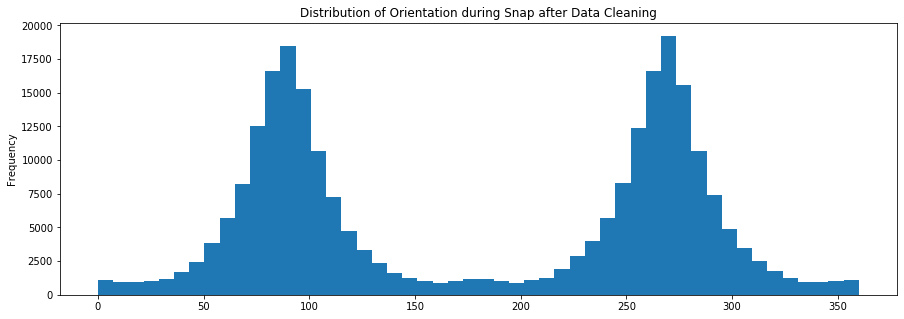

In [36]:
tracks.query('event == "ball_snap"')['o'] \
    .plot(kind='hist',
          bins=50,
          figsize=(15, 5),
          title='Distribution of Orientation during Snap after Data Cleaning')
plt.show()

Text(0.5, 1.0, 'Distribution')

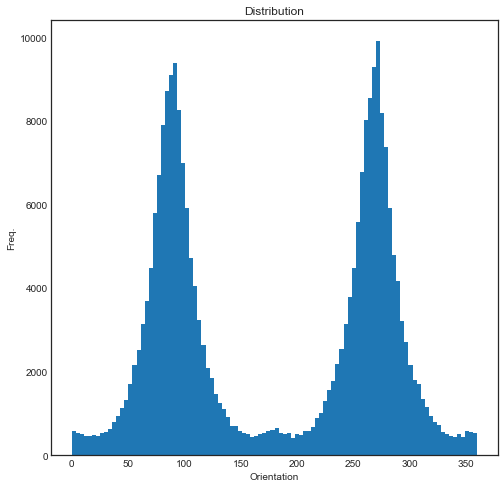

In [37]:
plt.style.use('seaborn-white')
plt.figure(figsize=(8,8))
plt.hist(tracks.query('event == "ball_snap"')['o'], density=False, bins=100)
plt.xlabel('Orientation')
plt.ylabel('Freq.')
plt.title('Distribution')

# plt.savefig('../out/test.png')

In [46]:
# O vs Dir feature
tracks['o_dir_diff1'] = np.abs(tracks['o'] - tracks['dir'])
tracks['o_dir_diff2'] = np.abs(tracks['o'] - (tracks['dir'] - 360))
tracks['o_dir_diff3'] = np.abs(tracks['o'] - (tracks['dir'] + 360))
tracks['o_dir_diff'] = tracks[['o_dir_diff1','o_dir_diff2','o_dir_diff3']].min(axis=1)
tracks = tracks.drop(['o_dir_diff1','o_dir_diff2','o_dir_diff3'], axis=1)

# Create movement groups
tracks['OffsetAngleGroup'] = 'Forward'
tracks.loc[tracks['o_dir_diff'] >= 45, 'OffsetAngleGroup'] = 'Lateral'
# tracks.loc[tracks['o_dir_diff'] >= 105, 'OffsetAngleGroup'] = 'Backpedal'
tracks['isLateralMovement'] = False
tracks.loc[tracks['OffsetAngleGroup'] == 'Lateral', 'isLateralMovement'] = True

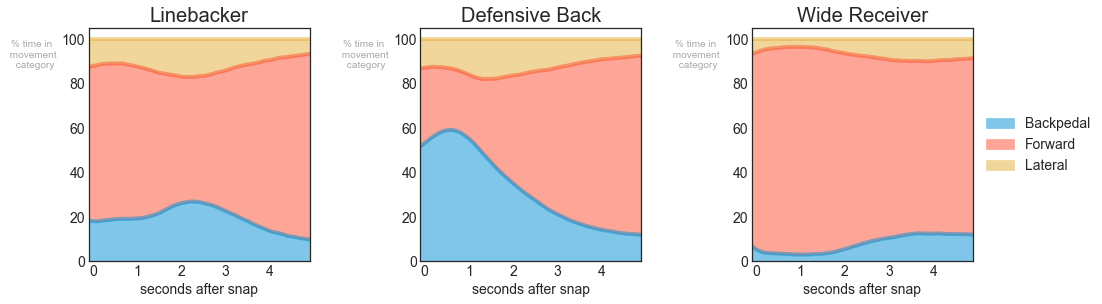

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Linebacker
ax=axes[0]
t_group = tracks.query('isRushPass and Position_inj == "Linebacker" and time_since_snap < 5 and s > 0') \
    .groupby(['time_since_snap','OffsetAngleGroup'])['OffsetAngleGroup'] \
    .count() \
    .unstack('OffsetAngleGroup')
t_group.apply(lambda x: 100 * x / float(x.sum()), axis=1) \
    .plot(kind='area', stacked=True, alpha=0.5, ax=ax, title='Linebacker')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_xlabel('seconds after snap', fontsize=14)
ax.set_ylabel('% time in \n movement \n category', rotation=0, fontsize=10, color='darkgrey')
ax.yaxis.set_label_coords(-0.25,0.82)

ax.get_legend().remove()

# Defensive Back
ax=axes[1]
t_group = tracks.query('isRushPass and Position_inj == "Defensive Back" and time_since_snap < 5 and s > 0') \
    .groupby(['time_since_snap','OffsetAngleGroup'])['OffsetAngleGroup'] \
    .count() \
    .unstack('OffsetAngleGroup')
t_group.apply(lambda x: 100 * x / float(x.sum()), axis=1).plot(kind='area', stacked=True, alpha=0.5, ax=ax, title='Defensive Back')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_xlabel('seconds after snap', fontsize=14)
ax.set_ylabel('% time in \n movement \n category', rotation=0, fontsize=10, color='darkgrey')
ax.yaxis.set_label_coords(-0.25,0.82)
ax.get_legend().remove()

# Wide Receiver
ax=axes[2]
t_group = tracks.query('isRushPass and Position_inj == "Wide Receiver" and time_since_snap < 5 and s > 0') \
    .groupby(['time_since_snap','OffsetAngleGroup'])['OffsetAngleGroup'] \
    .count() \
    .unstack('OffsetAngleGroup')
t_group.apply(lambda x: 100 * x / float(x.sum()), axis=1).plot(kind='area', stacked=True, alpha=0.5, ax=ax, title='Wide Receiver')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_xlabel('seconds after snap', fontsize=14)
ax.set_ylabel('% time in \n movement \n category', rotation=0, fontsize=10, color='darkgrey')
ax.yaxis.set_label_coords(-0.25,0.82)
# # Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

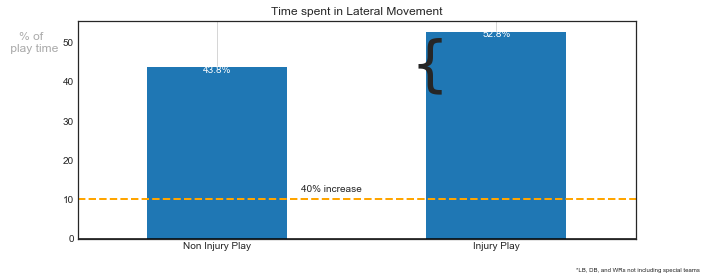

In [53]:
t_group = tracks[['s','isRushPass','isInjuryPronePos',
                  'PlayKey','OffsetAngleGroup','isInjuryPlay']] \
    .loc[tracks['isRushPass'] & tracks['isInjuryPronePos']] \
    .groupby(['OffsetAngleGroup','isInjuryPlay'])['PlayKey'] \
    .count() \
    .unstack(['OffsetAngleGroup'])

fig, ax = plt.subplots(1,1, figsize=(8, 8))
t_group.apply(lambda x: 100 * x / float(x.sum()), axis=1)['Lateral'] \
    .plot(kind='bar',
          title='Time spent in Lateral Movement',
          figsize=(10, 4),
         ax=ax)
ax.xaxis.set_label('')
ax.set_ylabel('% of \n play time', rotation=0, color='darkgrey', fontsize=12)
ax.yaxis.set_label_coords(-0.08, 0.85)
ax.set_xlabel('')
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(),1)}%', (p.get_x() + 0.2, p.get_height() - 1.5), color='white')
ax.set_xticklabels(['Non Injury Play', 'Injury Play'], rotation=0)
ax.axhline(0, color='black')
ax.axhline(10.1, linestyle='--', linewidth=2, color='orange')
# fig.annotate('*Linebackers, Defensive Backs, and Cornerbacks, not including special teams', (0, -0.001), fontsize=8)

plt.figtext(0.99, 0.01,
            '*LB, DB, and WRs not including special teams',
            fontsize=6,
            horizontalalignment='right')
plt.annotate(r"$\{$",fontsize=60,
            xy=(0.58, 0.7), xycoords='figure fraction'
            )
plt.annotate('40% increase', xy=(0.3, 12))
plt.grid(b=None, axis='x')

OffsetAngleGroup  Forward  Lateral
isInjuryPlay                      
False             4797450  3744181
True                 1115     1248
OffsetAngleGroup    Forward    Lateral
isInjuryPlay                          
False             56.165503  43.834497
True              47.185781  52.814219


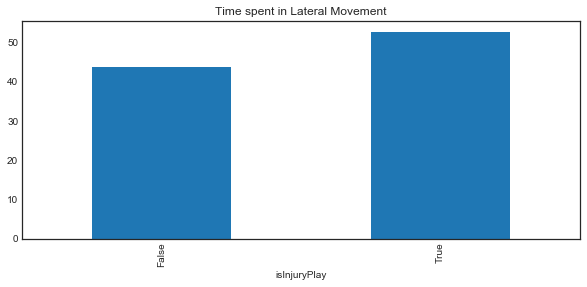

In [73]:
t_group = tracks[['s','isRushPass','isInjuryPronePos',
                  'PlayKey','OffsetAngleGroup','isInjuryPlay']] \
    .loc[tracks['isRushPass'] & tracks['isInjuryPronePos']] \
    .groupby(['OffsetAngleGroup','isInjuryPlay'])['PlayKey'] \
    .count() \
    .unstack(['OffsetAngleGroup'])

# when someone get injuryed in a match, the % of Lateral is 14%
# when none get injuryed in a match, the % of Lateral is 10%
print(t_group)
print(t_group.apply(lambda x: 100 * x / float(x.sum()), axis=1))

fig, ax = plt.subplots(1,1, figsize=(8, 8))
t_group.apply(lambda x: 100 * x / float(x.sum()), axis=1)['Lateral'] \
    .plot(kind='bar',
          title='Time spent in Lateral Movement',
          figsize=(10, 4),
         ax=ax)

In [55]:
print(t_group)
print(t_group.apply(lambda x: 100 * x / float(x.sum()), axis=1))


OffsetAngleGroup  Forward  Lateral
isInjuryPlay                      
False             4797450  3744181
True                 1115     1248
OffsetAngleGroup    Forward    Lateral
isInjuryPlay                          
False             56.165503  43.834497
True              47.185781  52.814219


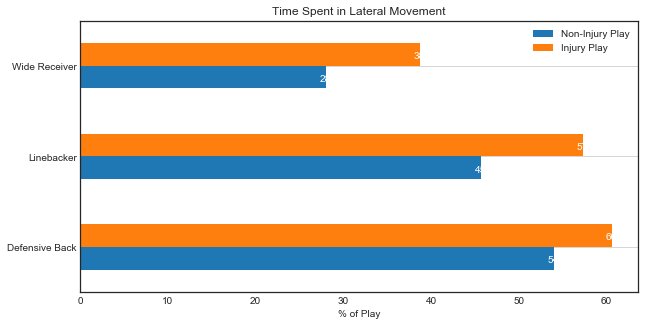

In [50]:
injury_prone_pos = ['Wide Receiver', 'Linebacker', 'Defensive Back']
ax = (tracks.query('Position_inj in @injury_prone_pos and isRushPass') \
    .groupby(['Position_inj','isInjuryPlay'])['isLateralMovement'].mean() * 100) \
    .unstack('isInjuryPlay').plot(kind='barh', figsize=(10, 5),
                                  title='Time Spent in Lateral Movement')

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-0.7, i.get_y()+.08, \
            str(int((i.get_width())))+'%', fontsize=10,
            color='white')

plt.legend(['Non-Injury Play', 'Injury Play'])
plt.xlabel('% of Play')
plt.ylabel('')
plt.grid(b=None, axis='y')

In [64]:
s_group = tracks[['s','a','a_abs','isRushPass','isInjuryPronePos',
                  'PlayKey','OffsetAngleGroup','isInjuryPlay']] \
    .groupby(['isInjuryPlay'])['s'] \
    .mean()

print(s_group)
# fig, ax = plt.subplots(1,1, figsize=(8, 8))
# s_group.apply(lambda x: 100 * x / float(x.sum()), axis=1)['Lateral'] \
#     .plot(kind='bar',
#           title='Time spent in Lateral Movement',
#           figsize=(10, 4),
#          ax=ax)

isInjuryPlay
False    2.638672
True     3.085938
Name: s, dtype: float16


In [ ]:
fig, ax= plt.subplots(1,1, figsize=(15, 5))
sns.distplot(tracks.query('FieldType == "Natural"')['o_dir_diff'].dropna(),
             hist=False, label='Natural', color='darkgreen')
sns.distplot(tracks.query('FieldType == "Synthetic"')['o_dir_diff'].dropna(),
             hist=False, label='Synthetic', color='mediumseagreen')
ax.set_ylabel('% of play time')
ax.set_xlabel('Orientation-Movement Angle')
ax.set_title('Player movement angle by Turf Type')
ax.legend(['Natural Turf', 'Synthetic Turf'])
plt.show()

In [ ]:
from scipy.stats import ks_2samp

ks_stat = ks_2samp(tracks.query('FieldType == "Natural"')['o_dir_diff'].dropna(),
        tracks.query('FieldType == "Synthetic"')['o_dir_diff'].dropna())[0]
print(f'The Kolmogorov-Smirnov statistic on 2 samples is {ks_stat:0.4f}')

In [ ]:
injury_prone_pos = ['Wide Receiver', 'Linebacker', 'Defensive Back']
my_colors = list(islice(cycle(['darkgreen','mediumseagreen']), None, 3))
ax = (tracks.query('Position_inj in @injury_prone_pos and isRushPass') \
    .groupby(['Position_inj','FieldType'])['isLateralMovement'].mean() * 100) \
    .unstack('FieldType').plot(kind='barh', figsize=(10, 5),
                               title='Time Spent in Lateral Movement',
                               color=my_colors)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-0.8, i.get_y()+.08, \
            str(round(i.get_width(), 2))+'%', fontsize=10,
            color='white')

plt.xlabel('% of Play')
plt.ylabel('')
plt.show()